In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def canny (image, low=10, high=30):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5),0)
    canny = cv2.Canny(blur,low, high) #get the outline of the strongest gradient
    return canny

In [3]:
def region_of_interest(image):
    height = image.shape[0]
    polygons = np.array([
    [(200,height), (1100, height), (550, 250)]
    ])
    mask = np.zeros_like(image)
    cv2.fillPoly(mask,polygons, 255)
    masked_image = cv2.bitwise_and(image,mask) #isolate region of interest
    
    return masked_image

In [4]:
def display_lines (image, lines):
    line_image = np.zeros_like(image)
    if lines is not None:
        for x1,y1,x2,y2 in lines:            
            cv2.line(line_image, (x1,y1), (x2,y2), (255,0,0), 10) #bgr, line thickness
    return line_image

In [5]:
def make_coordinates(image, line_parameters):
    slope, intercept = line_parameters
    y1 = image.shape[0]
    y2 = int(y1*(3/5))
    x1 = int ((y1 - intercept) / slope)
    x2 = int ((y2 - intercept) / slope)
    return np.array([x1,y1,x2,y2])

In [6]:
def average_slope_intercept(image, lines):
    left_fit = []
    right_fit = []
    left_line = 0,0,0,0
    right_line = 0,0,0,0
    for line in lines:
        x1, y1, x2, y2 = line.reshape(4)
        parameters = np.polyfit((x1, x2), (y1,y2), 1) #fist degree polynomial
        slope = parameters[0]
        intercept = parameters[1]
        if slope < 0:
            left_fit.append((slope,intercept))
        else:
            right_fit.append((slope,intercept))
    if len(left_fit) and len(right_fit):
        left_fit_average = np.average(left_fit, axis=0)
        right_fit_average = np.average(right_fit, axis=0)
        left_line = make_coordinates(image, left_fit_average)
        right_line = make_coordinates(image, right_fit_average)
    
    return np.array ([left_line, right_line])

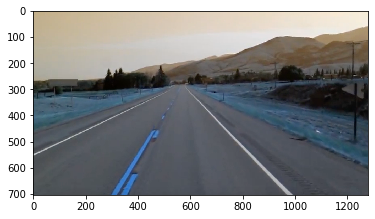

In [7]:
image = cv2.imread('test_image.jpg')
plt.imshow(image)
plt.show()

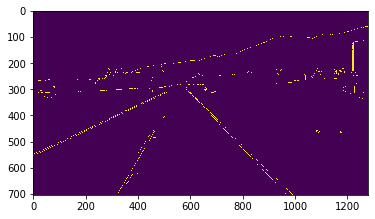

In [16]:
lane_image = np.copy(image) 
cannyIm = canny(lane_image,50,150)
#cv2 open in new window
#cv2.imshow("result",region_of_interest(cannyIm))
#cv2.waitKey(0)

plt.imshow(cannyIm)
plt.show()

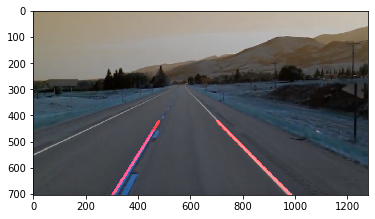

-1

In [14]:
croppedIm = region_of_interest(cannyIm)
lines = cv2.HoughLinesP(croppedIm,2,np.pi/180,100, np.array([]), minLineLength=40, maxLineGap=5) #2 px,1 rad precision, threshold
averaged_lines = average_slope_intercept (lane_image, lines)
line_image = display_lines (lane_image, averaged_lines)
combo_image = cv2.addWeighted(lane_image, 0.8, line_image, 1, 1 )
plt.imshow(combo_image)
plt.show()

cv2.imshow("result",combo_image)
cv2.waitKey(0)


In [15]:
cap = cv2.VideoCapture("test2.mp4")
prev_lines = 0
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret is True:
        canny_image = canny(frame)
        cropped_canny = region_of_interest(canny_image)
        lines = cv2.HoughLinesP(cropped_canny, 2, np.pi/180, 100, np.array([]), minLineLength=40,maxLineGap=5)
        try:
            averaged_lines = average_slope_intercept(frame, lines)
            line_image = display_lines(frame, averaged_lines)
            prev_lines = averaged_lines
        except:
            line_image = line_image = display_lines(frame, prev_lines)
        combo_image = cv2.addWeighted(frame, 0.8, line_image, 1, 1)
        cv2.imshow("result", combo_image)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break
cap.release()
cv2.destroyAllWindows()